In [1]:
using Distributions
using Random
using StatsPlots
default(fmt=:png, titlefontsize=12)

ecdf_(A, x) = count(≤(x), A) / length(A)

ecdf_ (generic function with 1 method)

In [2]:
function tvalue_welch(m, x̄, sx², n, ȳ, sy²; Δμ=0)
    (x̄ - ȳ - Δμ) / √(sx²/m + sy²/n)
end

function tvalue_welch(x, y; Δμ=0)
    m, x̄, sx² = length(x), mean(x), var(x)
    n, ȳ, sy² = length(y), mean(y), var(y)
    tvalue_welch(m, x̄, sx², n, ȳ, sy²; Δμ)
end

function degree_of_freedom_welch(m, sx², n, sy²)
    (sx²/m + sy²/n)^2 / ((sx²/m)^2/(m-1) + (sy²/n)^2/(n-1))
end

function degree_of_freedom_welch(x, y)
    m, sx² = length(x), var(x)
    n, sy² = length(y), var(y)
    degree_of_freedom_welch(m, sx², n, sy²)
end

function pvalue_welch(m, x̄, sx², n, ȳ, sy²; Δμ=0)
    t = tvalue_welch(m, x̄, sx², n, ȳ, sy²; Δμ)
    ν = degree_of_freedom_welch(m, sx², n, sy²)
    2ccdf(TDist(ν), abs(t))
end

function pvalue_welch(x, y; Δμ=0)
    m, x̄, sx² = length(x), mean(x), var(x)
    n, ȳ, sy² = length(y), mean(y), var(y)
    pvalue_welch(m, x̄, sx², n, ȳ, sy²; Δμ)
end

function confint_welch(m, x̄, sx², n, ȳ, sy²; α=0.05)
    ν = degree_of_freedom_welch(m, sx², n, sy²)
    c = quantile(TDist(ν), 1-α/2)
    SEhat = √(sx²/m + sy²/n)
    [x̄-ȳ-c*SEhat, x̄-ȳ+c*SEhat]
end

function confint_welch(x, y; α=0.05)
    m, x̄, sx² = length(x), mean(x), var(x)
    n, ȳ, sy² = length(y), mean(y), var(y)
    confint_welch(m, x̄, sx², n, ȳ, sy²; α)
end

confint_welch (generic function with 2 methods)

In [3]:
s²_student(m, sx², n, sy²) = ((m-1)*sx² + (n-1)*sy²)/(m+n-2)

function tvalue_student(m, x̄, sx², n, ȳ, sy²; Δμ=0)
    s² = s²_student(m, sx², n, sy²)
    (x̄ - ȳ - Δμ) / √(s²*(1/m + 1/n))
end

function tvalue_student(x, y; Δμ=0)
    m, x̄, sx² = length(x), mean(x), var(x)
    n, ȳ, sy² = length(y), mean(y), var(y)
    tvalue_student(m, x̄, sx², n, ȳ, sy²; Δμ)
end

function pvalue_student(m, x̄, sx², n, ȳ, sy²; Δμ=0)
    t = tvalue_student(m, x̄, sx², n, ȳ, sy²; Δμ)
    2ccdf(TDist(m+n-2), abs(t))
end

function pvalue_student(x, y; Δμ=0)
    m, x̄, sx² = length(x), mean(x), var(x)
    n, ȳ, sy² = length(y), mean(y), var(y)
    pvalue_student(m, x̄, sx², n, ȳ, sy²; Δμ)
end

function confint_student(m, x̄, sx², n, ȳ, sy²; α=0.05)
    c = quantile(TDist(m+n-2), 1-α/2)
    s² = s²_student(m, sx², n, sy²)
    SEhat = √(s²*(1/m + 1/n))
    [x̄-ȳ-c*SEhat, x̄-ȳ+c*SEhat]
end

function confint_student(x, y; α=0.05)
    m, x̄, sx² = length(x), mean(x), var(x)
    n, ȳ, sy² = length(y), mean(y), var(y)
    confint_student(m, x̄, sx², n, ȳ, sy²; α)
end

confint_student (generic function with 2 methods)

In [4]:
using Distributions
using Roots

winrate(X, Y) = mean((x < y) + (x == y)/2 for x in X, y in Y)

function brunner_munzel_test(X, Y; p=1/2, α=0.05)
    phat = winrate(X, Y)
    m, n = length(X), length(Y)
    sx2 = 1/(m-1) * sum(x -> (mean(y -> (y < x) + (y == x)/2, Y) - (1 - phat))^2, X)
    sy2 = 1/(n-1) * sum(y -> (mean(x -> (x < y) + (x == y)/2, X) - phat)^2, Y)
    sehat = √(sx2/m + sy2/n)
    tvalue = (phat - p)/sehat
    df = (sx2/m + sy2/n)^2 / ((sx2/m)^2/(m-1) + (sy2/n)^2/(n-1))
    pvalue = sehat > 0 ? 2ccdf(TDist(df), abs(tvalue)) : phat ≈ p ? 1.0 : 0.0
    c = sehat > 0 ? cquantile(TDist(df), α/2) : 0.0
    confint_p = (phat - c*sehat, phat + c*sehat)
    (; p, phat, sehat, tvalue, df, pvalue, α, confint_p)
end

pvalue_brunner_munzel(X, Y; p=1/2) = brunner_munzel_test(X, Y; p).pvalue

function _pvalue_brunner_munzel(p, phat, sehat, df)
    tvalue = (phat - p)/sehat
    sehat > 0 ? 2ccdf(TDist(df), abs(tvalue)) : phat ≈ p ? 1.0 : 0.0
end

function confint_bm_p_roots(X, Y; α=0.05)
    f(p) = brunner_munzel_test(X, Y; p).pvalue - α
    find_zeros(f, -1, 2)
end

function aminamax(X, Y)
    xmin, xmax = extrema(X)
    ymin, ymax = extrema(Y)
    width = max(xmax, ymax) - min(xmin, ymin)
    xmin - ymax - max(0.1, 0.05width), xmax - ymin + max(0.1, 0.05width)
end

function tieshift(X, Y; p=1/2)
    f(a) = winrate(X, Y .+ a) - p
    amin, amax = aminamax(X, Y)
    find_zero(f, (amin, amax))
end

function confint_bm_tieshift(X, Y; α=0.05)
    f(a) = brunner_munzel_test(X, Y .+ a).pvalue - α
    amin, amax = aminamax(X, Y)
    find_zeros(f, amin, amax)
end

confint_bm_tieshift (generic function with 1 method)

In [5]:
function mann_whitney_u_test(X, Y; correct=true)
    m, n = length(X), length(Y)
    phat = mean((x < y) + (x == y)/2 for x in X, y in Y)
    sehat = √((m+n+1)/(12m*n))
    zvalue = (phat - 1/2)/sehat
    correction = correct/(2m*n*sehat)
    pvalue = 2ccdf(Normal(), max(0, abs(zvalue) - correction))
    (; phat, sehat, zvalue, pvalue)
end

pvalue_mann_whitney_u_test(X, Y; correct=true) = mann_whitney_u_test(X, Y; correct).pvalue

using HypothesisTests
X = randn(100)
Y = randn(100)
@show pvalue_mann_whitney_u_test(X, Y) pvalue(ApproximateMannWhitneyUTest(X, Y))
X = randn(10)
Y = randn(10)
@show pvalue_mann_whitney_u_test(X, Y) pvalue(ApproximateMannWhitneyUTest(X, Y));

pvalue_mann_whitney_u_test(X, Y) = 0.7984650346891905
pvalue(ApproximateMannWhitneyUTest(X, Y)) = 0.7984650346891896
pvalue_mann_whitney_u_test(X, Y) = 0.47267559351158733
pvalue(ApproximateMannWhitneyUTest(X, Y)) = 0.47267559351158717


In [6]:
function sim_pvalues(;
        distx = Normal(0, 1),
        disty = Normal(0, 1),
        m = 50,
        n = 50,
        L = 10^5,
        np = true
    )
    pval_s = zeros(L)
    pval_w = zeros(L)
    if np
        pval_mw = zeros(L)
        pval_bm = zeros(L)
    else
        pval_mw = zeros(0)
        pval_bm = zeros(0)
    end
    Xtmp = [zeros(m) for _ in 1:Threads.nthreads()]
    Ytmp = [zeros(n) for _ in 1:Threads.nthreads()]
    Threads.@threads :static for i in 1:L
        tid = Threads.threadid()
        X = rand!(distx, Xtmp[tid])
        Y = rand!(disty, Ytmp[tid])
        pval_s[i] = pvalue_student(X, Y)
        pval_w[i] = pvalue_welch(X, Y)
        if np
            pval_mw[i] = pvalue_mann_whitney_u_test(X, Y)
            pval_bm[i] = pvalue_brunner_munzel(X, Y)
        end
    end
    (; pval_s, pval_w, pval_mw, pval_bm)
end

function powers(;
        distx = Normal(0, 1),
        disty = Normal(0, 1),
        m = 50,
        n = 50,
        L = 10^5,
        α = 0.05,
        np = false,
    )
    (; pval_s, pval_w, pval_mw, pval_bm) = sim_pvalues(; distx, disty, m, n, L, np)
    power_s = ecdf_(pval_s, α)
    power_w = ecdf_(pval_w, α)
    if np
        power_mw = ecdf_(pval_mw, α)
        power_bm = ecdf_(pval_bm, α)
    else
        power_mw = NaN
        power_bm = NaN
    end
    (; power_s, power_w, power_mw, power_bm)
end

function plot_powers(;
        Δμ = 0.0,
        σratios = 1:1:10,
        xticks = σratios,
        m = 50,
        n = 50,
        L = 10^5,
        α = 0.05,
        np = false,
        kwargs...
    )
    powers_s = zeros(length(σratios))
    powers_w = similar(powers_s)
    if np
        powers_mw = similar(powers_s)
        powers_bm = similar(powers_s)
    else
        powers_mw = zeros(0)
        powers_bm = zeros(0)
    end
    for (i, σratio) in enumerate(σratios)
        distx = Normal(0, 1)
        disty = Normal(Δμ, σratio)
        (; power_s, power_w, power_mw, power_bm) = powers(; distx, disty, m, n, L, α, np)
        powers_s[i] = power_s
        powers_w[i] = power_w
        if np
            powers_mw[i] = power_mw
            powers_bm[i] = power_bm
        end
    end
    plot(σratios, powers_s; marker=:o, msc=:auto, label="Student", c=1)
    plot!(σratios, powers_w; marker=:star, msc=:auto, label="Welch", ls=:dash, c=2)
    np && plot!(σratios, powers_mw; marker=:utriangle, msc=:auto, label="MW", ls=:dashdot, c=3)
    np && plot!(σratios, powers_bm; marker=:diamond, msc=:auto, label="BM", ls=:dashdotdot, c=4)
    plot!(; ylim=(-0.03, 1.03))
    plot!(; xticks, yticks=0:0.05:1)
    yguide = Δμ == 0 ? "α-error rate" : "power"
    plot!(; xguide="s₂/s₁", yguide)
    Δμstr = Δμ == 0 ? "0" : Δμ != 1 ? "$(Δμ)s₁" : "s₁"
    title!("Δμ=$Δμstr,  n₁=$m,  n₂=$n   (sim_iters=$L)")
    plot!(; size=(500, 300))
    plot!(; kwargs...)
end

plot_powers (generic function with 1 method)

  1.937343 seconds (7.48 M allocations: 895.297 MiB, 6.75% gc time, 810.17% compilation time: 1% of which was recompilation)


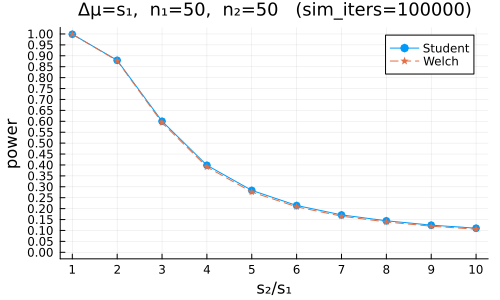

In [7]:
@time plot_powers(; Δμ=1)

  0.423474 seconds (5.61 M allocations: 828.252 MiB, 44.98% gc time, 1.16% compilation time)


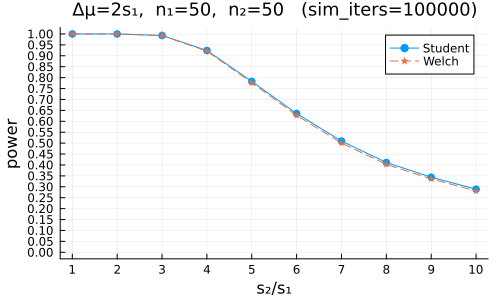

In [8]:
@time plot_powers(; Δμ=2)

  0.455101 seconds (5.61 M allocations: 828.389 MiB, 43.54% gc time, 2.95% compilation time)


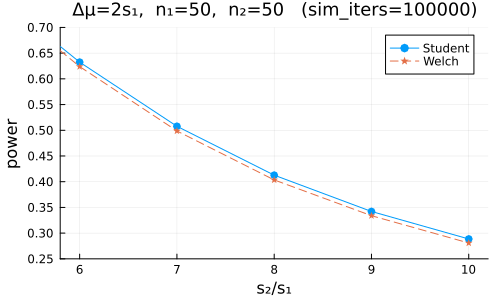

In [9]:
@time plot_powers(; Δμ=2, xlim=(5.8, 10.2), ylim=(0.25, 0.70))

  2.724119 seconds (32.12 M allocations: 4.071 GiB, 20.48% gc time, 0.38% compilation time)


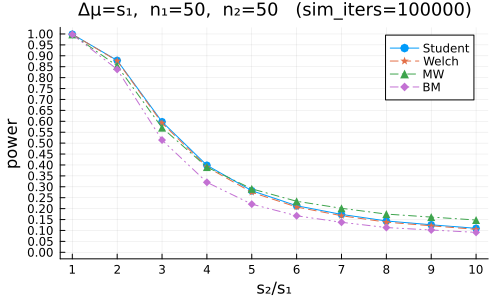

In [10]:
@time plot_powers(; Δμ=1, np=true)

  2.757370 seconds (32.40 M allocations: 4.111 GiB, 21.30% gc time)


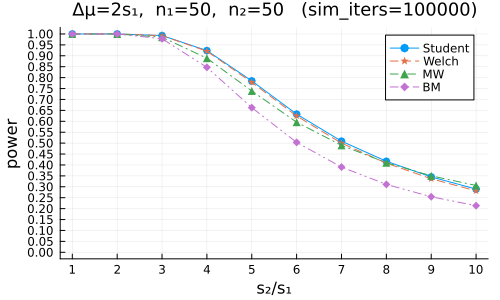

In [11]:
@time plot_powers(; Δμ=2, np=true)

  2.833641 seconds (32.40 M allocations: 4.110 GiB, 23.26% gc time)


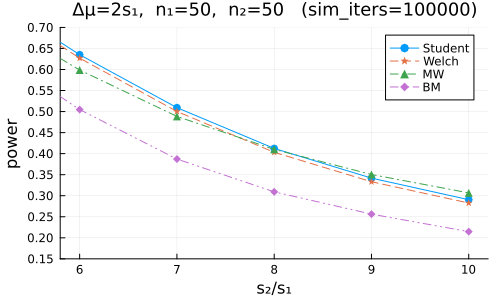

In [12]:
@time plot_powers(; Δμ=2, xlim=(5.8, 10.2), ylim=(0.15, 0.70), np=true)

 26.817906 seconds (258.47 M allocations: 38.076 GiB, 25.25% gc time, 0.17% compilation time)


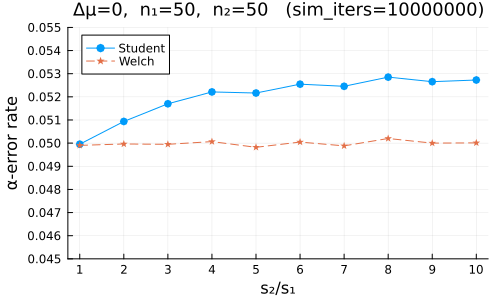

In [13]:
@time plot_powers(; Δμ=0, ylim=(0.045, 0.055), L=10^7, ytick=0:0.001:1)

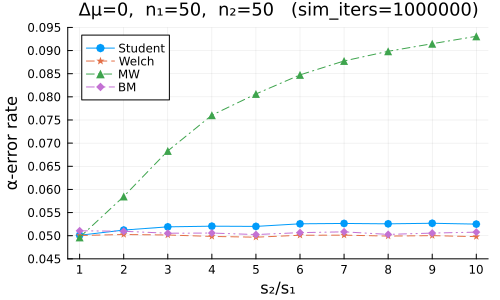

 27.367502 seconds (282.28 M allocations: 35.193 GiB, 19.29% gc time)


In [14]:
@time plot_powers(; Δμ=0, ylim=(0.045, 0.095), L=10^6, ytick=0:0.005:1, np=true)

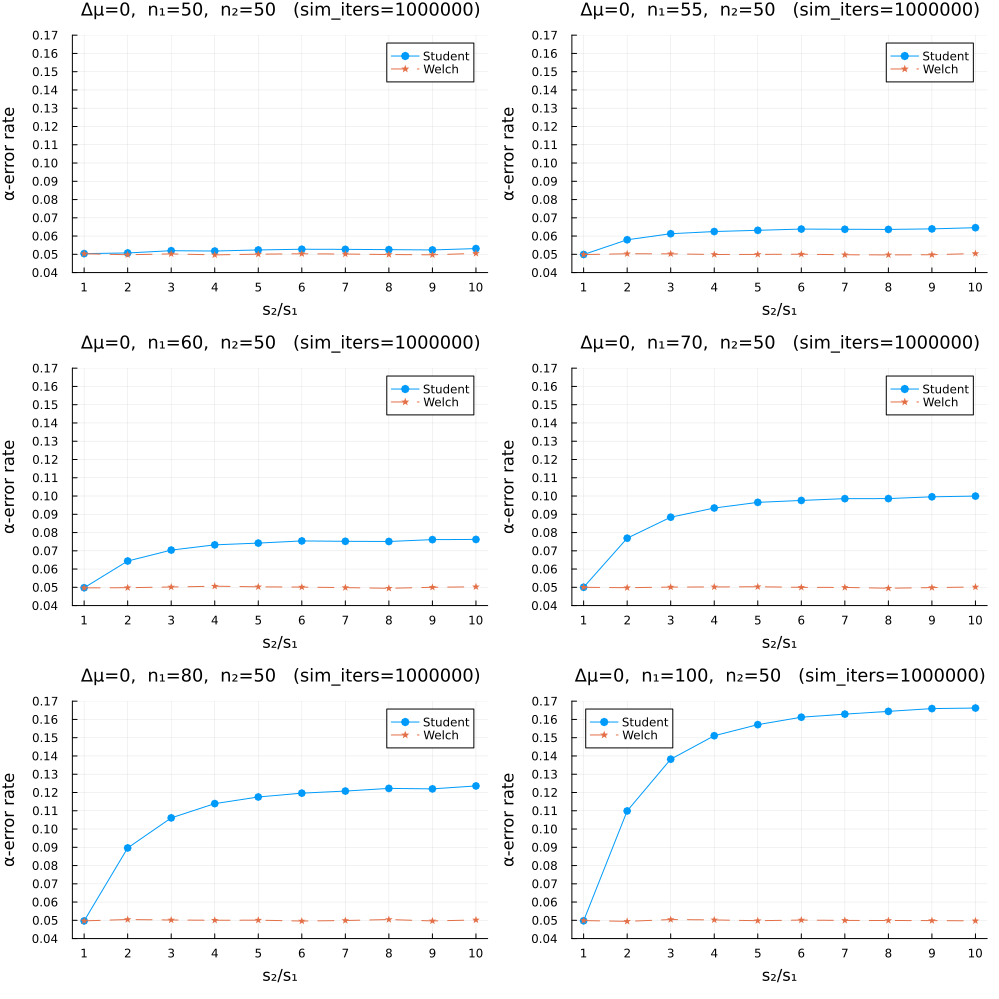

In [15]:
PP = []
for m in (50, 55, 60, 70, 80, 100)
    P = plot_powers(; Δμ=0, m, n=50, ylim=(0.04, 0.17), L=10^6, ytick=0:0.01:1)
    push!(PP, P)
end
plot(PP...; size=(1000, 1000), layout=(3, 2))

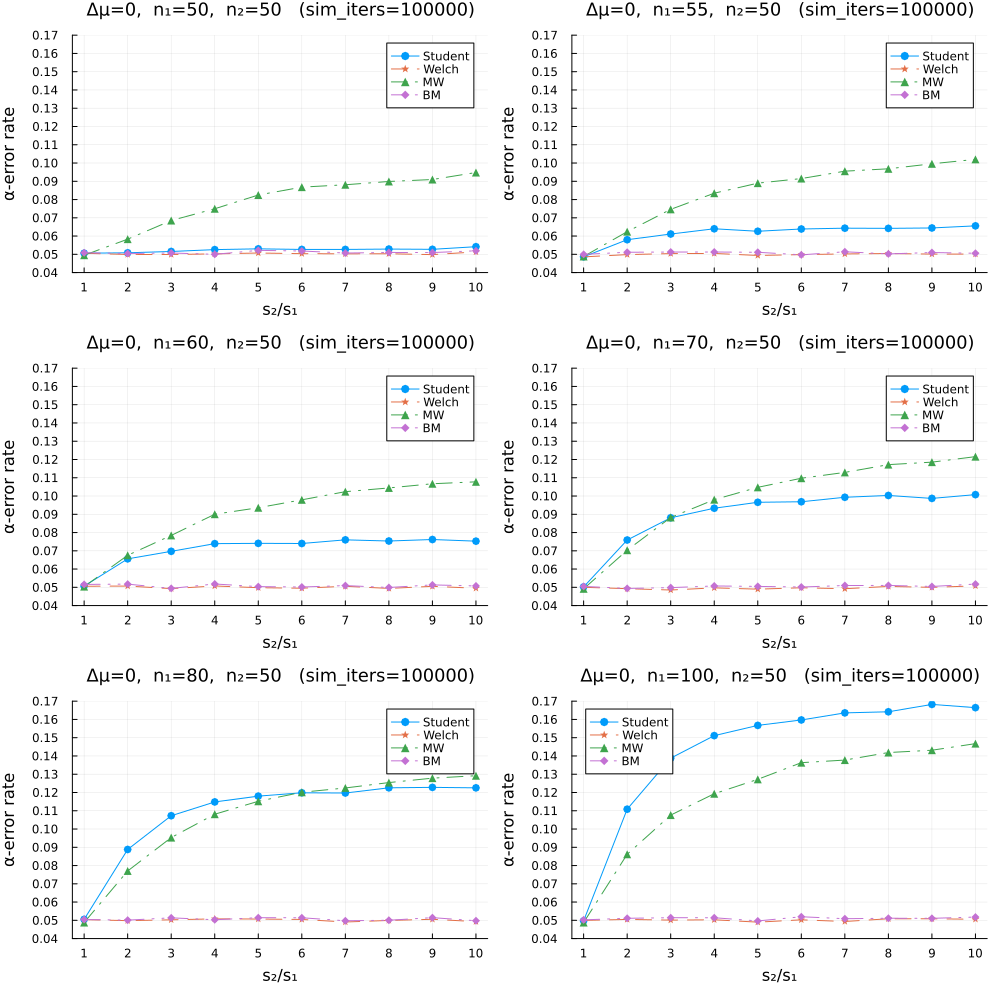

In [16]:
PP = []
for m in (50, 55, 60, 70, 80, 100)
    P = plot_powers(; Δμ=0, m, n=50, ylim=(0.04, 0.17), L=10^5, ytick=0:0.01:1, np=true)
    push!(PP, P)
end
plot(PP...; size=(1000, 1000), layout=(3, 2))

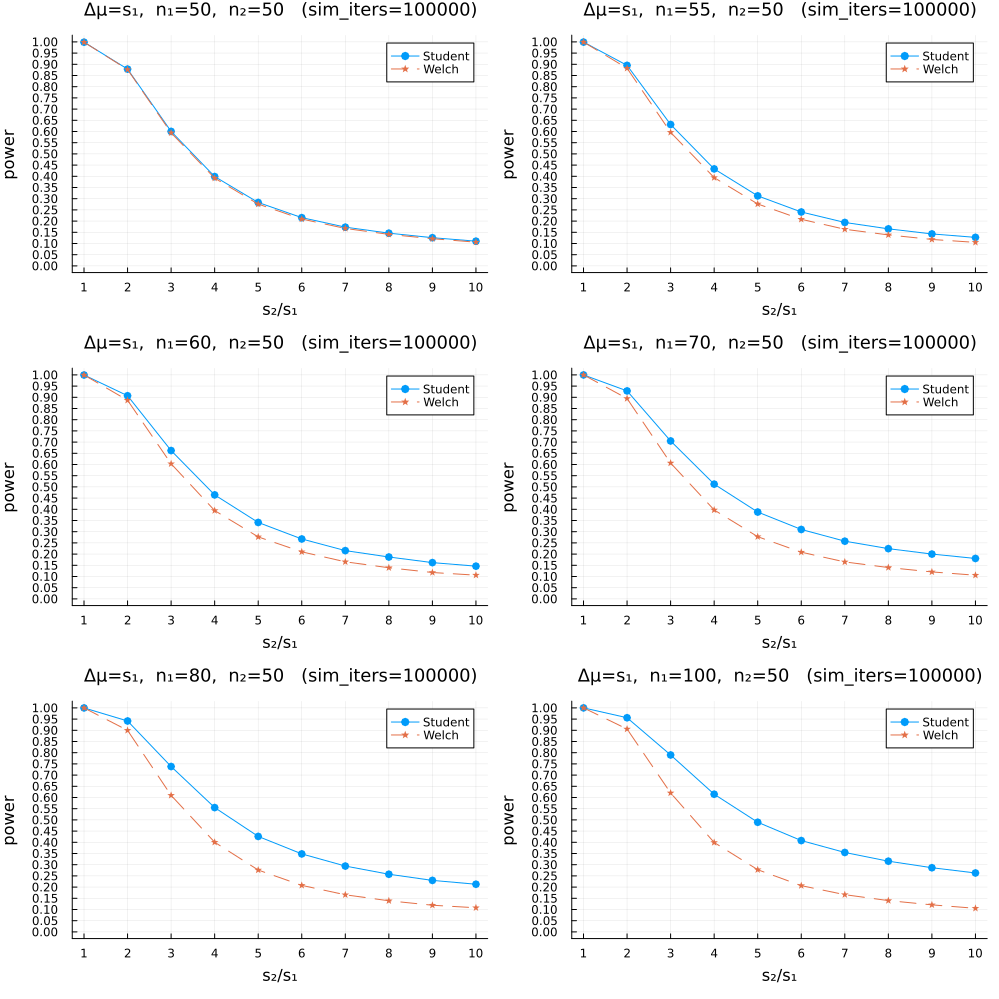

In [17]:
PP = []
for m in (50, 55, 60, 70, 80, 100)
    P = plot_powers(; Δμ=1, m, n=50)
    push!(PP, P)
end
plot(PP...; size=(1000, 1000), layout=(3, 2))

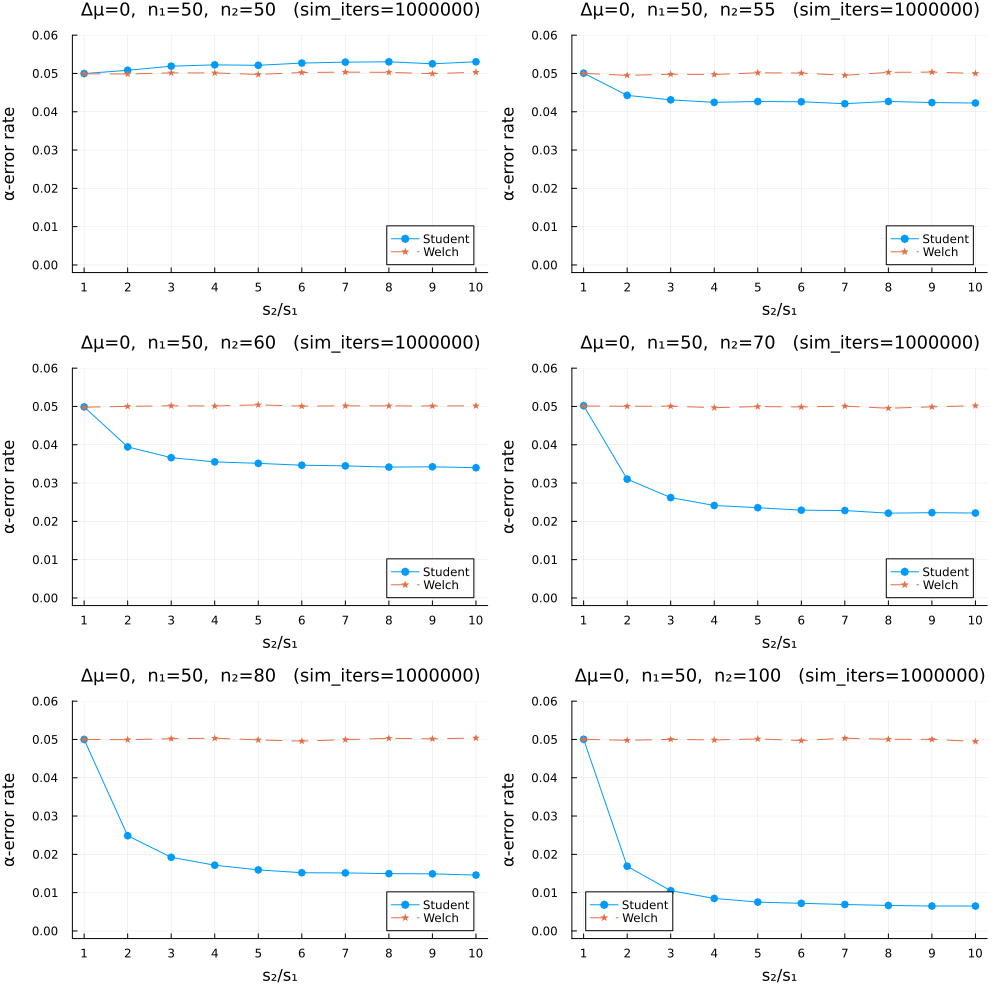

In [18]:
PP = []
for n in (50, 55, 60, 70, 80, 100)
    P = plot_powers(; Δμ=0, m=50, n, ylim=(-0.002, 0.06), L=10^6, ytick=0:0.01:1)
    push!(PP, P)
end
plot(PP...; size=(1000, 1000), layout=(3, 2))

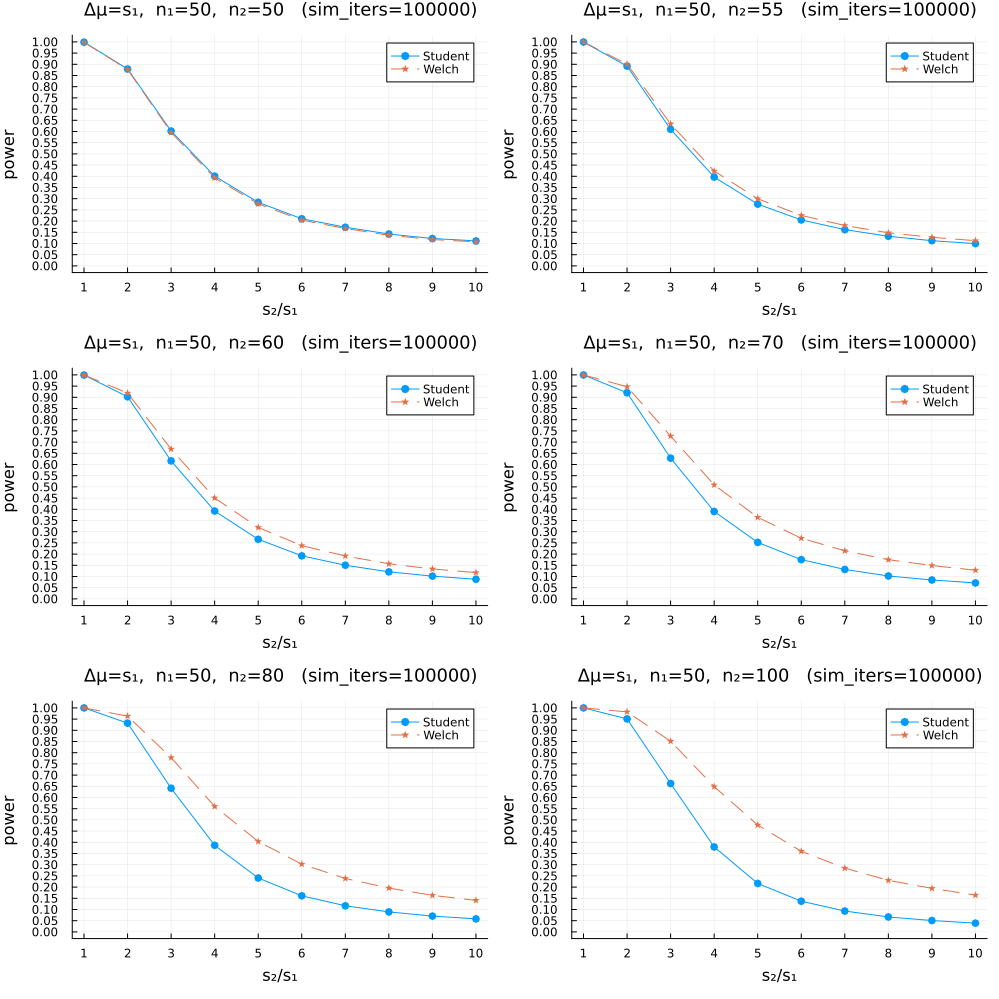

In [19]:
PP = []
for n in (50, 55, 60, 70, 80, 100)
    P = plot_powers(; Δμ=1, m=50, n)
    push!(PP, P)
end
plot(PP...; size=(1000, 1000), layout=(3, 2))

 22.630514 seconds (233.33 M allocations: 34.520 GiB, 26.77% gc time)


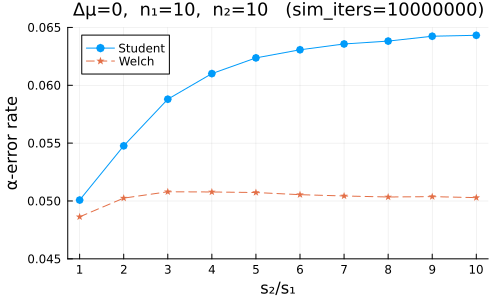

In [20]:
@time plot_powers(; Δμ=0, m=10, n=10, ylim=(0.045, 0.065), L=10^7, ytick=0:0.005:1)

  9.665310 seconds (127.92 M allocations: 13.341 GiB, 26.41% gc time)


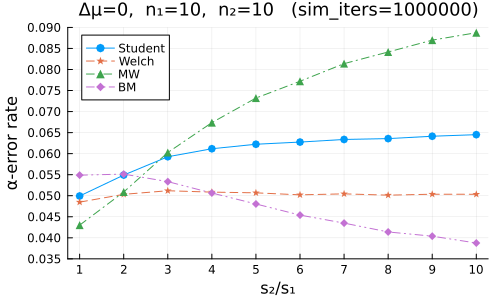

In [21]:
@time plot_powers(; Δμ=0, m=10, n=10, ylim=(0.035, 0.090), L=10^6, ytick=0:0.005:1, np=true)

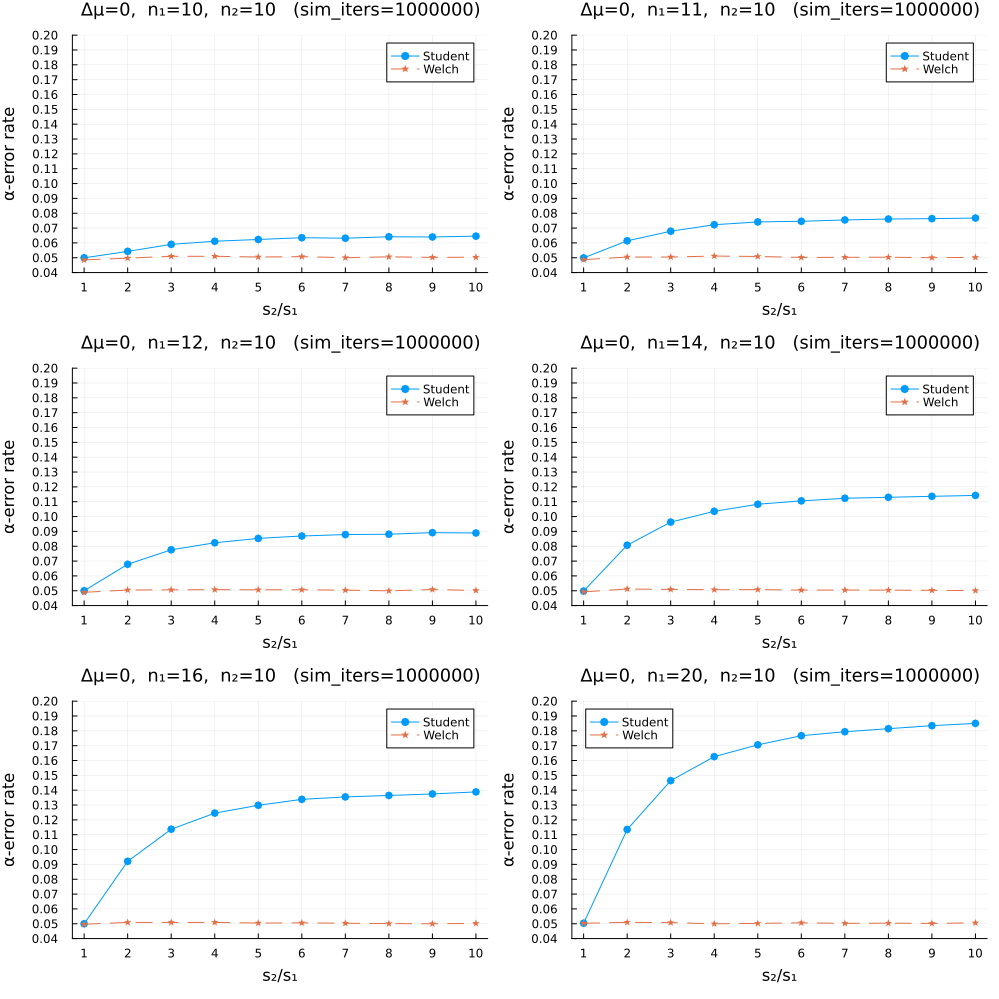

In [22]:
PP = []
for m in (10, 11, 12, 14, 16, 20)
    P = plot_powers(; Δμ=0, m, n=10, ylim=(0.04, 0.20), L=10^6, ytick=0:0.01:1)
    push!(PP, P)
end
plot(PP...; size=(1000, 1000), layout=(3, 2))

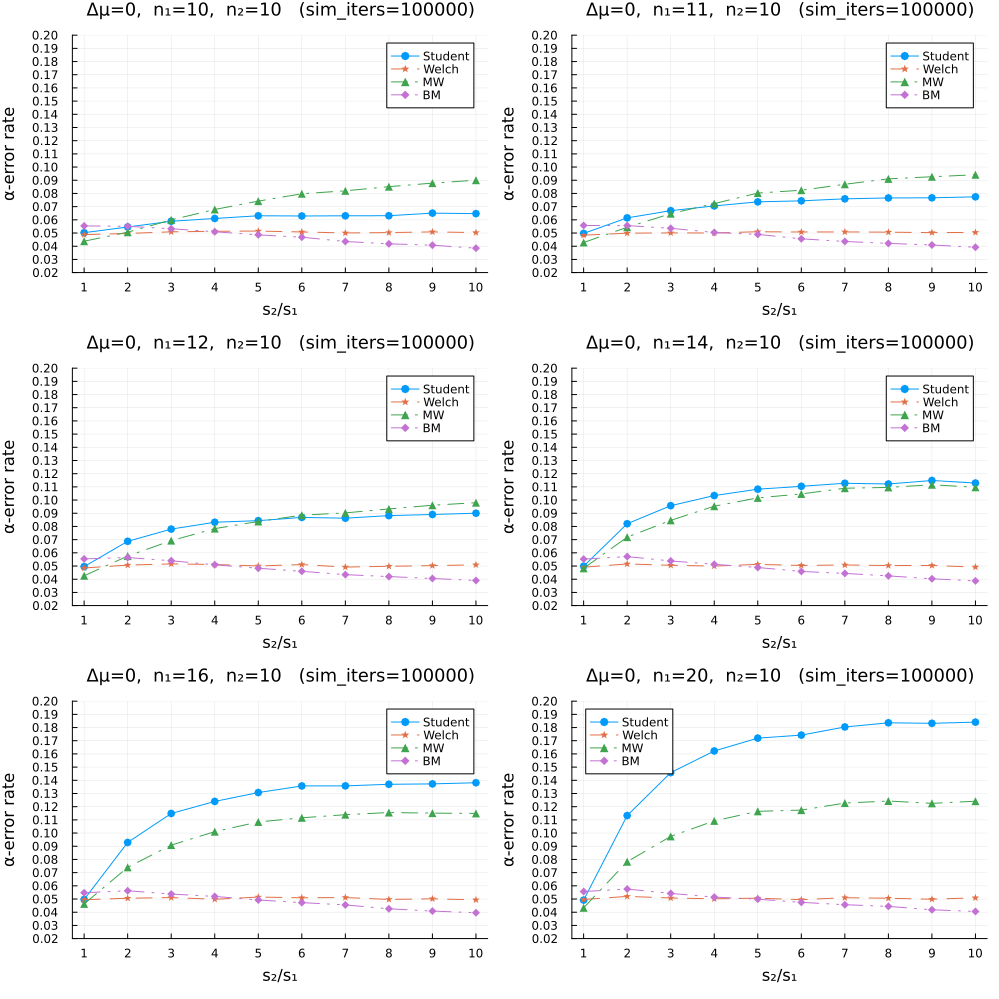

In [23]:
PP = []
for m in (10, 11, 12, 14, 16, 20)
    P = plot_powers(; Δμ=0, m, n=10, ylim=(0.02, 0.20), L=10^5, ytick=0:0.01:1, np=true)
    push!(PP, P)
end
plot(PP...; size=(1000, 1000), layout=(3, 2))